# QM9 Pro.
Not sure what I’m supposed to call this file.  
Plan is to keep this repo much neater than before.  
Getting to work now.

In [19]:
import torch_geometric
import torch
import os
from torch.nn import Module, Embedding, Linear, MSELoss
from torch.optim import Adam
from torch_geometric.nn import global_mean_pool
import torch.optim.lr_scheduler as lr_scheduler
from torch_geometric.datasets import QM9
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
import wandb

In [20]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'main.ipynb'
wandb.login()
torch.manual_seed(2002)

In [21]:
dataset = QM9(root='QM9/')

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/data/dataset.py:242: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [36]:
config_1 = {
    "base_learning_rate": 1e-3,
    "architecture": "Sparse 2-layer MPNN",
    "optimizer": "Adam",
    "scheduler": "ReduceLROnPlateau",
    "dataset": "QM9",
    "epochs": 10,
    "batch_size": 128,
}

config_2 = {
    "base_learning_rate": 1e-3,
    "architecture": "Sparse 2-layer MPNN",
    "optimizer": "Adam",
    "scheduler": "COSINEANNEALINGLR",
    "dataset": "QM9",
    "epochs": 10,
    "batch_size": 128,
}

config_3 = {
    "base_learning_rate": 1e-3,
    "architecture": "x",
    "optimizer": "Adam",
    "scheduler": "ReduceLROnPlateau",
    "dataset": "QM9",
    "epochs": 10,
    "batch_size": 128,
}

config_4 = {
    "base_learning_rate": 1e-3,
    "architecture": "x",
    "optimizer": "Adam",
    "scheduler": "COSINEANNEALINGLR",
    "dataset": "QM9",
    "epochs": 10,
    "batch_size": 128,
}

In [23]:
class GCN(torch.nn.Module):
    def __init__(self):
        self.emb_dim = 32
        super().__init__()
        
        self.embedding = Embedding(118, self.emb_dim)
        self.conv1 = GCNConv(self.emb_dim, self.emb_dim)
        self.conv2 = GCNConv(self.emb_dim, self.emb_dim)
        self.lin1 = torch.nn.Linear(self.emb_dim, 8)
        self.lin2 = torch.nn.Linear(8, 1)

    def forward(self, data):
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        x = data.x

        x = self.embedding(x)
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        
        x = global_mean_pool(x, data.batch)
        
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        
        return x

In [24]:
model = GCN()

In [34]:
# wandb project init
wandb.init(
    project="QM9-Pro",
    config = config_1
)

# hyperparameter init
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.3, patience=1)
num_epochs = 10

# stats
train_losses = [[]] * num_epochs
val_losses = [[]] * num_epochs
val_mean_losses = []
test_losses = []

for epoch in range(num_epochs):
    i = 0
    # training loop
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        y = data.y
        y_hat = model(data).view(-1)
        loss = loss_fn(y_hat, y)
        loss.backward()
        losses[epoch].append(loss.item())
        optimizer.step()
        if i == 0:
            print(f'EPOCH {epoch+1} OF {num_epochs} | MOST RECENT TRAIN LOSS: {loss.item()}')
        i+=1
        i%=100
    
    # val
    model.eval()
    for data in val_loader:
        y = data.y
        y_hat = model(data).view(-1)
        loss = loss_fn(y_hat, y)
        val_losses[epoch].append(loss.item())
    val_mean_loss = torch.mean(torch.tensor(val_losses[epoch]))
    print(f'EPOCH {epoch+1} OF {num_epochs} | VAL MEAN LOSS: {val_mean_loss.item()}')
    val_mean_losses.append(val_mean_loss.item())
    
    scheduler.step(loss)

# test
model.eval()
for data in test_loader:
        y = data.y
        y_hat = model(data).view(-1)
        loss = loss_fn(y_hat, y)
        test_losses.append(loss.item())
    test_mean_loss = torch.mean(torch.tensor(test_losses))
    print(f'TEST MEAN LOSS: {test_mean_loss.item()}')

# log
wandb.log({"train_losses": train_losses, "val_losses": val_losses, 
           "val_mean_losses": val_mean_losses, "test_losses": test_losses, 
           "test_mean_loss": test_mean_loss})

wandb.finish()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 55)

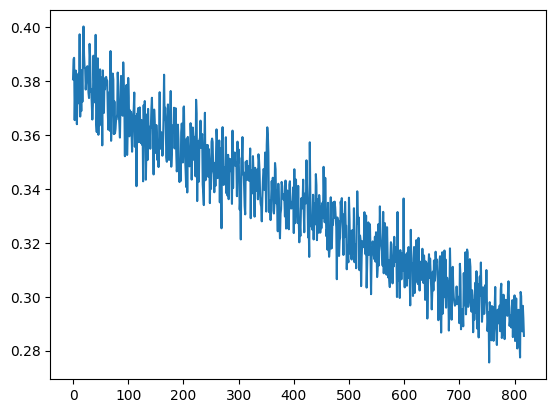

In [27]:
from matplotlib import pyplot
pyplot.plot(losses[0])